In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
data = pd.read_csv('preprocessed_telco_customer_data.csv')
data.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,False,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,34,1,0,56.95,1889.50,0,True,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,2,1,1,53.85,108.15,1,True,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,45,0,0,42.30,1840.75,0,True,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,2,1,1,70.70,151.65,1,False,...,False,False,False,False,False,False,False,False,True,False


In [4]:
X = data.drop('Churn', axis=1)
y = data['Churn']


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5634, 30), (1409, 30), (5634,), (1409,))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
y_pred = model.predict(X_test_scaled)


In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.81


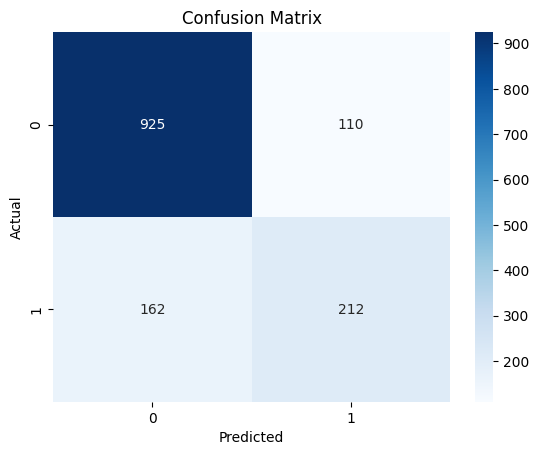

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

y_prob = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_prob)
auc


0.8415846443979436

In [13]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

feature_importance['Absolute'] = feature_importance['Coefficient'].abs()
feature_importance.sort_values(by='Absolute', ascending=False).head(10)

,Feature,Coefficient,Absolute
3,tenure,-1.219639,1.219639
6,MonthlyCharges,-0.921369,0.921369
11,InternetService_Fiber optic,0.778760,0.778760
26,Contract_Two year,-0.588975,0.588975
7,TotalCharges,0.497246,0.497246
25,Contract_One year,-0.286473,0.286473
24,StreamingMovies_Yes,0.258653,0.258653
22,StreamingTV_Yes,0.258042,0.258042
10,MultipleLines_Yes,0.216356,0.216356
5,PaperlessBilling,0.181833,0.181833


In [14]:
top_features = feature_importance.sort_values(
    by='Absolute', ascending=False
).head(8)

top_features


,Feature,Coefficient,Absolute
3,tenure,-1.219639,1.219639
6,MonthlyCharges,-0.921369,0.921369
11,InternetService_Fiber optic,0.778760,0.778760
26,Contract_Two year,-0.588975,0.588975
7,TotalCharges,0.497246,0.497246
25,Contract_One year,-0.286473,0.286473
24,StreamingMovies_Yes,0.258653,0.258653
22,StreamingTV_Yes,0.258042,0.258042


# Calculate Customer Lifetime Value (LTV)

In [15]:
data['LTV'] = data['MonthlyCharges'] * data['tenure']


In [16]:
ltv_threshold = data['LTV'].quantile(0.75)
data['HighValueCustomer'] = (data['LTV'] >= ltv_threshold).astype(int)


In [17]:
data['Churn_Probability'] = model.predict_proba(scaler.transform(X))[:, 1]


In [18]:
data['HighChurnRisk'] = (data['Churn_Probability'] >= 0.5).astype(int)


In [19]:
at_risk_high_value = data[
    (data['HighValueCustomer'] == 1) &
    (data['HighChurnRisk'] == 1)
]

at_risk_high_value.shape


(56, 35)

In [20]:
at_risk_high_value[['tenure', 'MonthlyCharges', 'LTV']].describe()


,tenure,MonthlyCharges,LTV
count,56.000000,56.000000,56.000000
mean,45.214286,100.473214,4539.069643
std,5.331601,4.485137,541.150286
min,38.000000,89.200000,3876.550000
25%,41.000000,97.025000,4047.637500
50%,43.500000,101.000000,4408.950000
75%,49.000000,103.912500,4842.912500
max,58.000000,113.200000,5736.200000


# Retention Strategies


Month-to-month contracts - Offer discounts for 1-year or 2-year contracts 
High monthly charges     - Personalized pricing or loyalty discounts      
Electronic check users   - Incentivize auto-payment methods               
Low tenure customers     - Onboarding support & early engagement          
No tech support/security - Bundle value-added services                    


In [21]:
potential_revenue_saved = at_risk_high_value['LTV'].sum()
potential_revenue_saved


254187.9